In [1]:
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import scikit_posthocs as posthocs
import seaborn as sns

from searchnets.utils.general import results_df

/home/ildefonso/anaconda3/envs/searchstims-new/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ildefonso/anaconda3/envs/searchstims-new/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ildefonso/anaconda3/envs/searchstims-new/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ilde

In [2]:
DATA_DIR = Path('/home/ildefonso/Documents/repositories/coding/L2M/visual-search-nets/data')

In [3]:
RESULTS_DIR = DATA_DIR.joinpath('results')
DATA_PREPD_DIR = DATA_DIR.joinpath('data_prepd_for_nets')

In [4]:
nets = ['alexnet']
train_types = [
    'finetune',
    'train',
    'train_big_set_size',
    'train_big_set_and_sample_size',
]
stims = [
    'RVvGV',
    'RVvRHGV',
    '2_v_5',
]

In [5]:
dfs_train_type = {}
results_gz_paths = []
data_gz_paths = []
for net in nets:
    for train_type in train_types:
        dfs_this_train_type = []
        for stim in stims:
            results_gz_dir = RESULTS_DIR.joinpath(
                f'{net}_{train_type}_{stim}'
            )
            results_gz = list(results_gz_dir.glob('searchnets*.gz'))
            assert len(results_gz) == 1, "found more than one .gz"
            if results_gz:
                results_gz_paths.extend(results_gz)
                results_gz = results_gz[0]
                data_gz = DATA_PREPD_DIR.joinpath(f'{net}_{train_type}_{stim}_data.gz')
                assert data_gz.exists(), f"couldn't find {data_gz}"
                data_gz_paths.append(data_gz)
                df = results_df(DATA_PREPD_DIR,
                                RESULTS_DIR,
                                nets=[net],
                                train_types=[train_type],
                                stims=[stim],
                                target_condition=['both',],
                                data_gz_paths=[data_gz],
                                results_gz_paths=[results_gz])
                dfs_this_train_type.append(df)
        dfs_this_train_type = pd.concat(dfs_this_train_type)
        dfs_train_type[train_type] = dfs_this_train_type

In [6]:
COLUMNS = [
    'train_type',
    'stimulus',
    'net_number',
    'min_set_size',
    'max_set_size',
    'acc_min_set_size',
    'acc_max_set_size',
    'acc_diff_min_max',
]

df_summary_d = {}
df_summary_rows = []
for train_type, df in dfs_train_type.items():
    df_rows_this_train_type = []
    for stim in stims:
        df_stim = df[df['stimulus'] == stim]
        set_sizes = df_stim['set_size'].unique()
        min_set_size = set_sizes.min()
        max_set_size = set_sizes.max()
        net_nums  = df_stim['net_number'].unique()
        for net_num in net_nums:
            min_acc = df_stim[
                (df_stim['net_number'] == net_num) & (df_stim['set_size'] == min_set_size)
            ]['accuracy'].values[0]
            max_acc = df_stim[
                (df_stim['net_number'] == net_num) & (df_stim['set_size'] == max_set_size)
            ]['accuracy'].values[0]
            acc_diff = min_acc - max_acc
            row = [
                train_type, stim, net_num, min_set_size, max_set_size, min_acc, max_acc, acc_diff,
            ]
            df_rows_this_train_type.append(row)
            df_summary_rows.append(row)
    df_this_train_type = pd.DataFrame.from_records(df_rows_this_train_type, columns=COLUMNS)
    df_summary_d[train_type] = df_this_train_type
        
df_summary = pd.DataFrame.from_records(df_summary_rows, columns=COLUMNS)

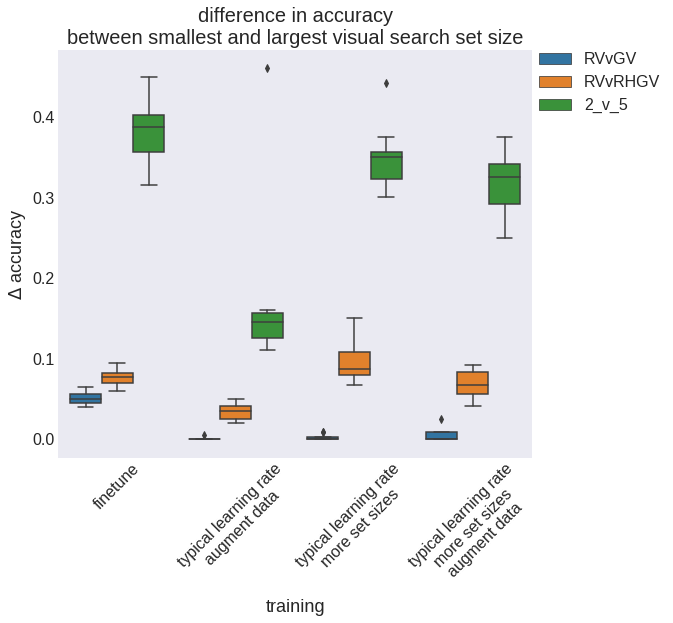

In [27]:
train_types_xlabels = [
    'finetune',
    'typical learning rate\naugment data',
    'typical learning rate\nmore set sizes',
    'typical learning rate\nmore set sizes\naugment data',
]

fig, ax = plt.subplots(figsize=(10,7.5))
sns.boxplot(x='train_type', y='acc_diff_min_max', data=df_summary,
            hue='stimulus', ax=ax)
ax.set_title('difference in accuracy\nbetween smallest and largest visual search set size')
ax.set_xlabel('training')
ax.set_xticklabels(labels=train_types_xlabels, rotation=45)
ax.set_ylabel('$\Delta$ accuracy')
bbox = ax.get_position()
ax.set_position([bbox.x0, bbox.y0, bbox.width * 0.85, bbox.height])
ax.legend(loc='center right', bbox_to_anchor=(1.3, 0.92), ncol=1);
plt.savefig('/home/ildefonso/Documents/repositories/coding/L2M/visual-search-nets/docs/static/'
            'acc_diff.png', bbox_inches = "tight")

In [8]:
# [group["variable"].values for name, group in df.groupby("treatment")]
out_d = {train_type: {} for train_type in train_types}
for name, group in df_summary.groupby(["train_type", "stimulus"]):
    out_d[name[0]][name[1]] = group['acc_diff_min_max'].values 

Test whether any group violates normality assumption

In [9]:
for train_type, groups_dict in out_d.items():
    for stim, val in groups_dict.items():
        H, p = scipy.stats.normaltest(val)
        if p < 0.01:
            signif = ', significant'
        else:
            signif = ', not signficant'
        print(f'p value for {train_type}, {stim}: {p}{signif}')

p value for finetune, 2_v_5: 0.9882120107798485, not signficant
p value for finetune, RVvGV: 0.7922169594153441, not signficant
p value for finetune, RVvRHGV: 0.9755154503210208, not signficant
p value for train, 2_v_5: 2.9112571310194575e-05, significant
p value for train, RVvGV: 1.0347922859049848e-05, significant
p value for train, RVvRHGV: 0.4611482942674858, not signficant
p value for train_big_set_size, 2_v_5: 0.07089342106334028, not signficant
p value for train_big_set_size, RVvGV: 0.15942217054385618, not signficant
p value for train_big_set_size, RVvRHGV: 0.16606972884612053, not signficant
p value for train_big_set_and_sample_size, 2_v_5: 0.8371465332687209, not signficant
p value for train_big_set_and_sample_size, RVvGV: 0.004223932611732589, significant
p value for train_big_set_and_sample_size, RVvRHGV: 0.7110233868102801, not signficant


/home/ildefonso/anaconda3/envs/searchstims-new/lib/python3.6/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


Only two are significant.

Test whether populations have equal variance.

In [10]:
P_THRESH = 0.01
print("Bartlett's test for equal variance")
for train_type, groups_dict in out_d.items():
    groups = [groups_dict[stim] for stim in stims]
    H, p = scipy.stats.bartlett(*groups)
    if p < P_THRESH:
        signif = ', significant'
    else:
        signif = ', not signficant'
    print(f'p value for {train_type}: {p}{signif}')

Bartlett's test for equal variance
p value for finetune: 5.195276767533548e-05, significant
p value for train: 8.64917978842222e-15, significant
p value for train_big_set_size: 1.0149478786166611e-05, significant
p value for train_big_set_and_sample_size: 0.0016460327541486497, significant


Suggests that groups do not have equal variance.  
Boxplot agrees with this, esp for 2_v_5 condition variance is always greater.  
Probably better to use nonparametric test.

In [11]:
stats_d = {}
for train_type, groups_dict in out_d.items():
    groups = [groups_dict[stim] for stim in stims]
    stat, p_val = scipy.stats.kruskal(*groups)
    stats_d[train_type] = {
        'stat': stat, 'p_val': p_val,
    }

In [12]:
for train_type, stat_dict in stats_d.items():
    p_val = stat_dict['p_val']
    if p_val < P_THRESH:
        signif = ', significant'
    else:
        signif = ', not signficant'

    print(f'p value: {p_val:8.7f}{signif}')

p value: 0.0000442, significant
p value: 0.0000273, significant
p value: 0.0000294, significant
p value: 0.0000319, significant


In [13]:
df_summary_d['finetune']

,train_type,stimulus,net_number,min_set_size,max_set_size,acc_min_set_size,acc_max_set_size,acc_diff_min_max
0,finetune,RVvGV,0,1,8,1.000,0.960,0.040
1,finetune,RVvGV,1,1,8,1.000,0.950,0.050
2,finetune,RVvGV,2,1,8,1.000,0.950,0.050
3,finetune,RVvGV,3,1,8,1.000,0.945,0.055
4,finetune,RVvGV,4,1,8,1.000,0.935,0.065
5,finetune,RVvGV,5,1,8,1.000,0.940,0.060
6,finetune,RVvGV,6,1,8,1.000,0.955,0.045
7,finetune,RVvGV,7,1,8,1.000,0.955,0.045
8,finetune,RVvRHGV,0,1,8,1.000,0.910,0.090
9,finetune,RVvRHGV,1,1,8,1.000,0.940,0.060


In [14]:
conover = {}
all_all_signif = []
for train_type, df in df_summary_d.items():
    posthoc_result = posthocs.posthoc_conover(df, 
                                              val_col='acc_diff_min_max',
                                              group_col='stimulus',
                                              p_adjust = 'holm')
    result_mat = posthoc_result.values
    diag = np.eye(result_mat.shape[0])
    not_diag = np.logical_not(diag)
    are_all_signif = np.all(result_mat[not_diag] < P_THRESH)
    all_all_signif.append(are_all_signif)
    print(f'{train_type}, all pairwise comparisons significantly different: {are_all_signif}')

print()
if all(all_all_signif):
    print('All pairwise comparisons were significantly different across training conditions')
else:
    print('All pairwise comparisons were *not* significantly different across training conditions')

finetune, all pairwise comparisons significantly different: True
train, all pairwise comparisons significantly different: True
train_big_set_size, all pairwise comparisons significantly different: True
train_big_set_and_sample_size, all pairwise comparisons significantly different: True

All pairwise comparisons were significantly different across training conditions
